# Exercise 1: CNN with Subclassing (5 marks) #

* Objective: Build a CNN for handwritten digit recognition using the MNIST dataset.
* Dataset: <b>MNIST</b>


In [41]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [42]:
# Load and prepare the MNIST dataset.
mnist = tf.keras.datasets.mnist
#
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")


In [43]:
# Use tf.data to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


In [44]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # Added another Conv2D layer and tuned filters/kernels
        self.conv1 = Conv2D(32, kernel_size=3, activation='relu')
        self.conv2 = Conv2D(64, kernel_size=3, activation='relu')  # New conv layer, more filters
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)  # New conv layer in the call method
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)
# Instantiate model
model = MyModel()

In [45]:
# Choose an optimizer and loss function for training:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

    

In [46]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [47]:
# Use tf.GradientTape to train the model:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
    

In [48]:
# Test the model:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)
    

In [57]:
EPOCHS = 5

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    # Reset metrics at the start of each epoch
    train_loss.reset_state()
    train_accuracy.reset_state()
    test_loss.reset_state()
    test_accuracy.reset_state()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    train_losses.append(train_loss.result().numpy())
    test_losses.append(test_loss.result().numpy())
    train_accuracies.append(train_accuracy.result().numpy())
    test_accuracies.append(test_accuracy.result().numpy())

    print(f"Epoch {epoch + 1}, "
          f"Loss: {train_loss.result():.4f}, "
          f"Accuracy: {train_accuracy.result() * 100:.2f}%, "
          f"Test Loss: {test_loss.result():.4f}, "
          f"Test Accuracy: {test_accuracy.result() * 100:.2f}%")

Epoch 1, Loss: 0.0059, Accuracy: 99.82%, Test Loss: 0.0676, Test Accuracy: 98.63%
Epoch 2, Loss: 0.0071, Accuracy: 99.78%, Test Loss: 0.0561, Test Accuracy: 98.75%
Epoch 3, Loss: 0.0042, Accuracy: 99.86%, Test Loss: 0.0557, Test Accuracy: 98.98%
Epoch 4, Loss: 0.0057, Accuracy: 99.82%, Test Loss: 0.0666, Test Accuracy: 98.74%
Epoch 5, Loss: 0.0044, Accuracy: 99.85%, Test Loss: 0.0534, Test Accuracy: 99.00%


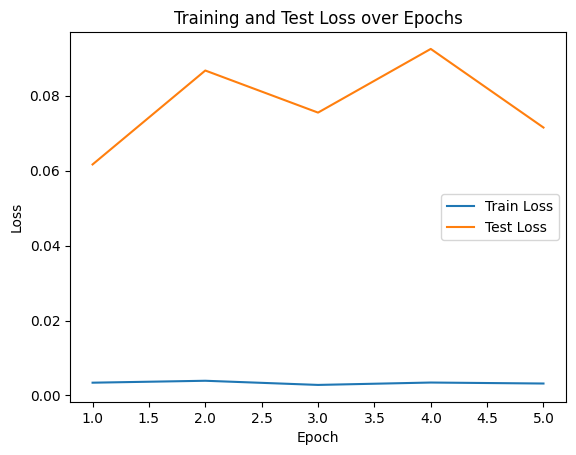

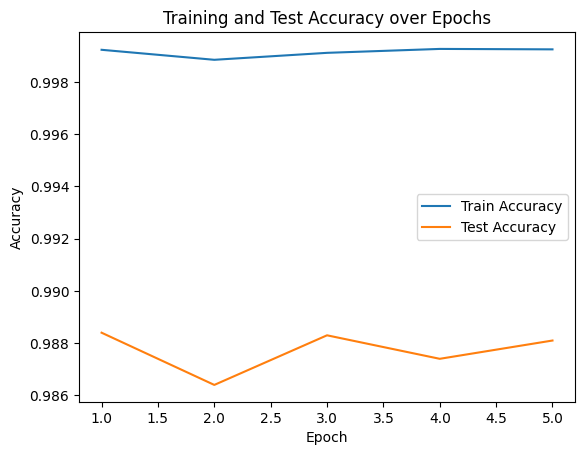

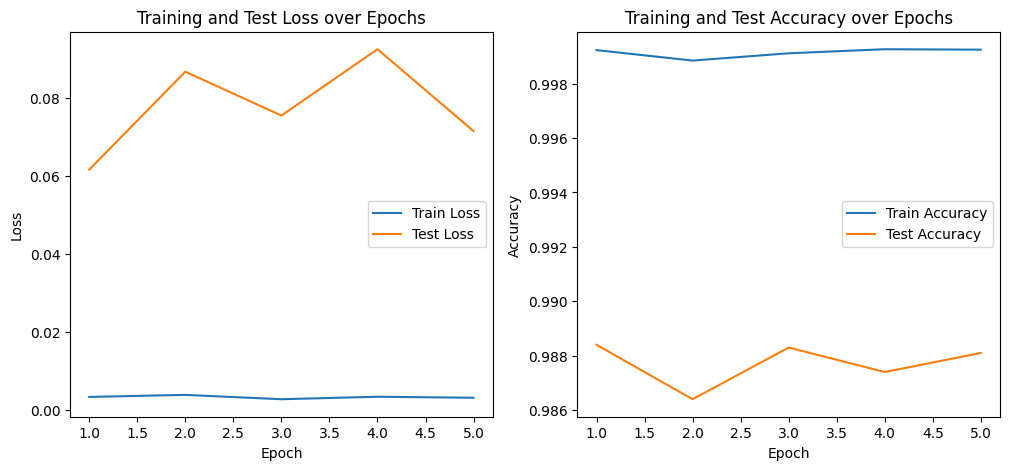

In [60]:
import matplotlib.pyplot as plt

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(EPOCHS):
    train_loss.reset_state()          # correct singular method
    train_accuracy.reset_state()      # fix: was reset_states()
    test_loss.reset_state()
    test_accuracy.reset_state()       # fix: was reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    train_losses.append(train_loss.result().numpy())
    test_losses.append(test_loss.result().numpy())
    train_accs.append(train_accuracy.result().numpy())
    test_accs.append(test_accuracy.result().numpy())

# Plot Loss
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(range(1, EPOCHS + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()

# Combined figure with subplots (optional)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()

plt.show()
